In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spatialdata_io
import spatialdata as sd
import scanpy as sc

# while not pip installable, add path to file 
import sys
sys.path.append("../../src")
import troutpy 


/home/sergio/.local/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/sergio/.local/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/sergio/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/sergio/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
xenium_path_cropped='/media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr'
output_path='/media/sergio/Discovair_final/analysis_crop'
sdata=sd.read_zarr(xenium_path_cropped)

/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/

In [3]:
adata=sdata['table']

In [4]:
adata.raw=adata
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [5]:
adata.layers["raw"] = adata.X.copy()
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

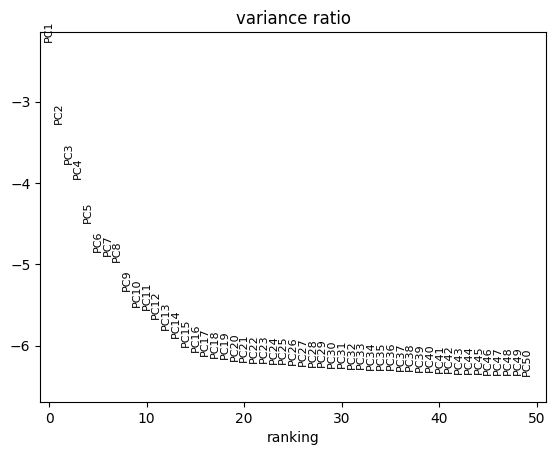

In [6]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [7]:
sc.pp.neighbors(adata)

/home/sergio/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
sc.tl.umap(adata)
sc.tl.leiden(adata,key_added='leiden')

/tmp/ipykernel_1333321/2468996503.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata,key_added='leiden')


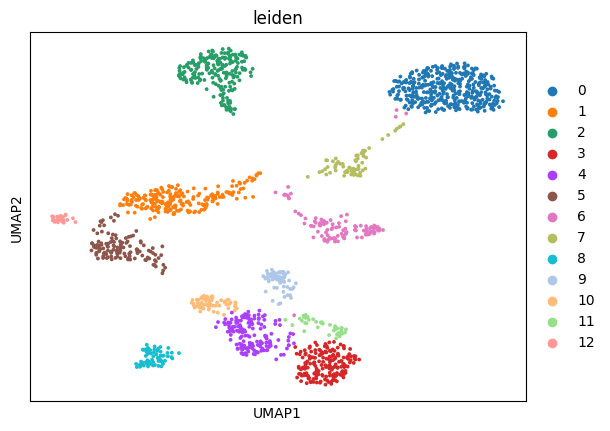

In [9]:
sc.pl.umap(adata,color="leiden",size=30)

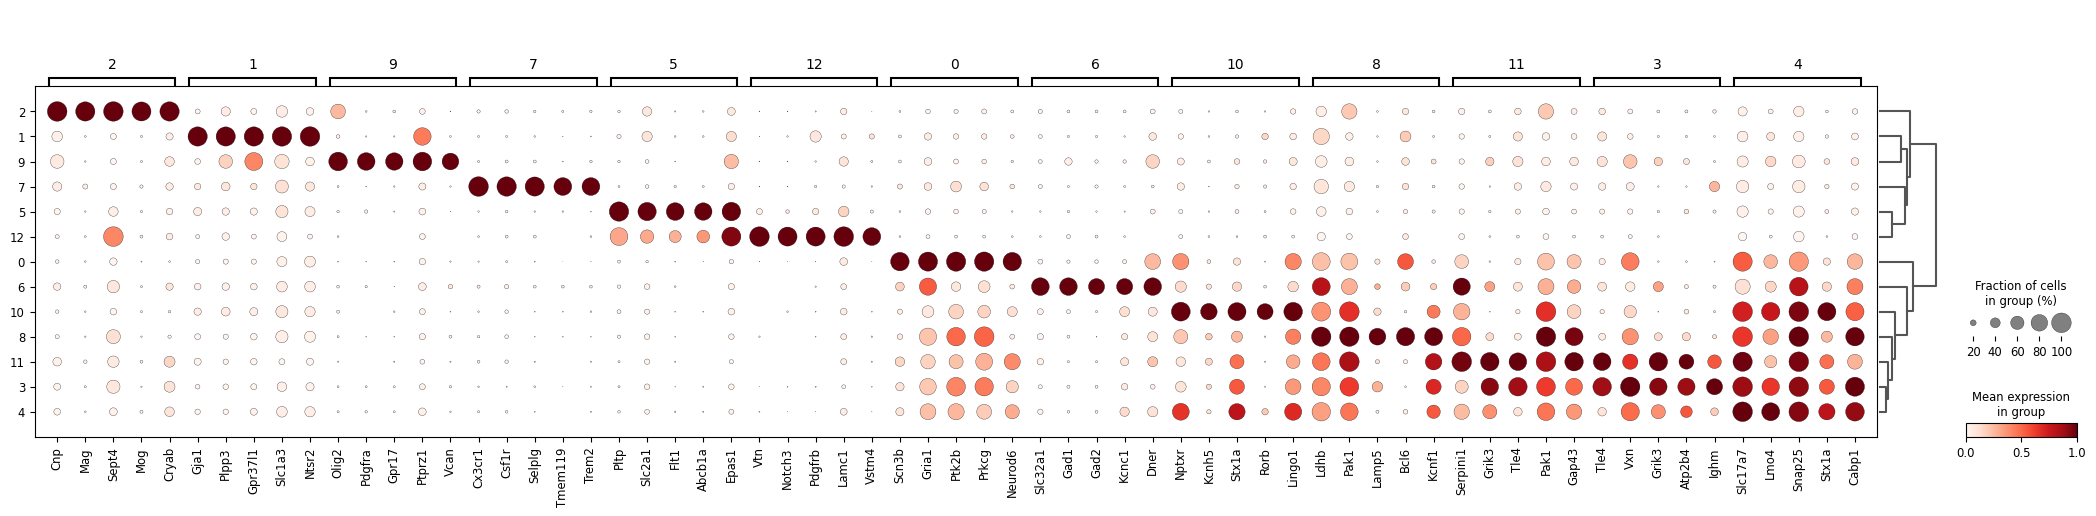

In [10]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5
)

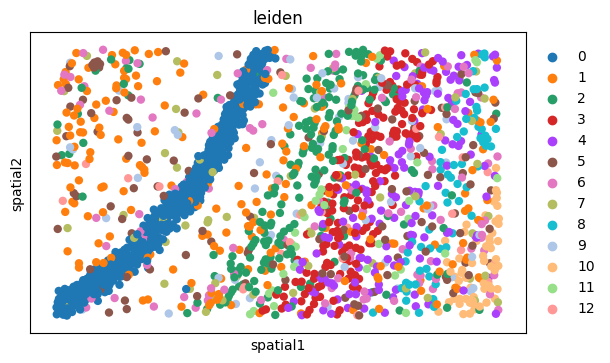

In [11]:
sc.pl.spatial(adata,color='leiden',spot_size=20)

## Annotate segmented cells

In [12]:
anndict={'0':'CA','1':'Astro','2':'Oligo','3':'3','4':'4','5':'5','6':'INH','7':'7','8':'','9':'9','10':'10','11':'11','12':'12'}
adata.obs['cell type']=adata.obs['leiden'].map(anndict)

In [13]:
xenium_path_cropped='/media/sergio/Discovair_final/mousebrain_prime_crop_points2regions_annotated.zarr'
sdata.write(xenium_path_cropped,overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions_annotated.zarr).     
         Please see the documentation of `is_self_contained()` to understand the implications of working with      
         SpatialData objects that are not self-contained.                                                          
INFO     The Zarr backing store has been changed from                                                              
         /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr the new file path:                
         /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions_annotated.zarr                         
